# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation du document</div></b>

In [1]:
import os
# import json
# @param ["tensorflow", "jax", "torch"]
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'  
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# os.environ['TF_XLA_FLAGS']='--tf_xla_auto_jit=1,--tf_xla_always_defer_compilation=true'
# os.environ['XLA_FLAGS']='--xla_backend_optimization_level=0,--xla_gpu_autotune_level=4,--xla_gpu_disable_ptxas_optimizations=true,--xla_gpu_use_cudnn_batchnorm_level=2'
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='5'

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Import libriries </div></b>

In [2]:
import numpy as np, pandas as pd, seaborn as sns, warnings, os, sys, pickle
from matplotlib import pyplot as plt
from datetime import datetime as dt

import matplotlib.font_manager as fm
from matplotlib.lines import Line2D

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

tf.get_logger().setLevel('ERROR')# Suppress TensorFlow logging (2)

In [4]:
print("Tensorflow\t : %s\tCUDA %s\tGPU %s\tXLA %s\nKeras\t\t : %s\nPandas\t\t : %s\nNumPy\t\t : %s"%
      (tf.__version__, 
       tf.test.is_built_with_cuda(), 
       tf.test.is_built_with_gpu_support(), 
       tf.test.is_built_with_xla(), 
       tf.keras.__version__, 
       pd.__version__, 
       np.__version__))

Tensorflow	 : 2.17.0	CUDA True	GPU True	XLA True
Keras		 : 3.6.0
Pandas		 : 2.2.2
NumPy		 : 1.26.4


# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation des GPUs presents</div></b>

In [5]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) >  0 :
    for i, gpu in enumerate(physical_devices):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)

    strategy = tf.distribute.experimental.CentralStorageStrategy()
    print('Le système est initialisé avec {0:d} GPUs'.format(strategy.num_replicas_in_sync))

Le système est initialisé avec 1 GPUs


I0000 00:00:1751702877.891823   81399 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1751702877.913937   81399 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1751702877.914056   81399 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1751702877.921313   81399 service.cc:146] XLA service 0x281f0b70 initialized for platfor

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Outils du document</div></b>

In [6]:
palette = [
            "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", "#d1e5f0", "#fddbc7",
            "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#f5054f", "#a0450e",
            "#0339f8", "#f4320c", "#fec615", "#017a79", "#85a3b2", "#fe2f4a", "#a00498", "#b04e0f",
            "#0165fc", "#ff724c", "#fddc5c", "#11875d", "#89a0b0", "#fe828c", "#cb00f5", "#b75203",
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#ffb7ce", "#c071fe", "#ca6b02",
            "#92c5de", "#f4a582", "#fef69e", "#18d17b", "#c5c9c7", "#ffcfdc", "#caa0ff", "#cb7723",
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#d8863b",
            "#030764", "#be0119", "#dbb40c", "#005249", "#3c4142", "#cb0162", "#5d1451", "#653700",
            "#040348", "#67001f", "#b27a01", "#002d04", "#000000", "#a0025c", "#490648", "#3c0008"
          ]

In [7]:
nom_projet                = "03-La création du modèle l'entrainement et l'exécution-fashionMNIST-Categorical"
repertoireProjet          = os.getcwd()
repertoireEnregistrement  = repertoireProjet +'/'+nom_projet+ '/repertoire.images'
repertoireSauvegardes     = repertoireProjet +'/'+nom_projet+ '/repertoire.sauvegardes'

def controleExistenceRepertoire(directory, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(directory)
    if path_exists:
        if not os.path.isdir(directory):
            raise Exception("Trouvé le nom "+directory+" mais c'est un fichier, pas un répertoire")
            return False
        return True
    if create_if_needed:
        os.makedirs(directory)
        
controleExistenceRepertoire(repertoireEnregistrement)
controleExistenceRepertoire(repertoireSauvegardes)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    plt.savefig(os.path.join(repertoireEnregistrement,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')


    
def sauvegarderModelPoids(model, fichierPoids, repertoireSauvegardes=repertoireSauvegardes):
    """Enregistrez les poids du modèle Keras."""
    if fichierPoids != None:
        controleExistenceRepertoire(repertoireSauvegardes)
        nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichierPoids))
        model.save_weights(nomFichier)

def sauvegarderModel(model, fichier, repertoireSauvegardes=repertoireSauvegardes):
    """Enregistrez le modèle Keras."""
    if fichier != None:
        controleExistenceRepertoire(repertoireSauvegardes)
        nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichier))
        model.save(nomFichier)

def lectureModelPoids(model, fichier, repertoireSauvegardes=repertoireSauvegardes):
    """Si le fichier existe, il est chargé et retourne True, sinon retourne False."""
    nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichier))
    if os.path.exists(nomFichier):
        if os.path.isfile(nomFichier):
            model.load_weights(nomFichier)
            return True
    return False

def sauvegardeHistorique(model,
                         repertoireSauvegardes,
                         nomSauvegarde='one_hidden_layer_history_batch_size_1'):

    history = pd.DataFrame( model.history)
    history.reset_index(inplace=True)
    history.rename(columns={'index':'epoch'},inplace=True)
    history.to_parquet(os.path.join(repertoireSauvegardes,f'{nomSauvegarde}.gzip'),compression='gzip', engine='pyarrow') 
    return history

def afficheHistoriqueEntrainement(history, palette):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(48,16));
    markersize = 8
    linewidth=2
    
    graph = sns.lineplot(x='epoch', 
                         y='accuracy',  
                         data=history,
                         ax=ax[0],      
                         label='accuracy',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[0],
                         );
    graph = sns.lineplot(x='epoch', 
                         y='val_accuracy',  
                         data=history,
                         ax=ax[0],      
                         label='val_accuracy',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[1],
                         );
    
    graph = sns.lineplot(x='epoch', 
                         y='loss',  
                         data=history,
                         ax=ax[1],      
                         label='loss',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[0],
                         );
    graph = sns.lineplot(x='epoch', 
                         y='val_loss',  
                         data=history,
                         ax=ax[1],      
                         label='val_loss',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[1],
                         );
    sauvegarderImage('afficheHistoriqueEntrainement')
    

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Lecture des données</div></b>

In [8]:
random_seed = 42
np.random.seed(random_seed)

# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# scale data to range [-0.5, 0.5]
X_train -= 0.5
X_test -= 0.5

# save the original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=number_of_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=number_of_classes)

In [9]:
dictLabels = {0:'T-shirt',
              1:'Pantalon',
              2:'Pull',
              3:'Robe',
              4:'Manteau',
              5:'Sandale',
              6:'Chemise',
              7:'Baskets',
              8:'Sac',
              9:'Bottines'}

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Création et compilation d'un modèle</div></b>

In [10]:
def make_one_hidden_layer_model():
    model = Sequential()
    model.add(Dense(number_of_pixels, 
                    activation='relu',
                    input_shape=[number_of_pixels]))
    model.add(Dense(number_of_classes, 
                    activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

# make the model
one_hidden_layer_model = make_one_hidden_layer_model()

In [11]:
one_hidden_layer_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 784)            │       615,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 623,290 (2.38 MB)

 Trainable params: 623,290 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Entrainement du modèle -Batch Size 1</div></b>


In [12]:
epochs=20
batch_size=1

one_hidden_layer_history = one_hidden_layer_model.fit( X_train.reshape((X_train.shape[0], number_of_pixels)), 
                                                       y_train, 
                                                       validation_data=(X_test.reshape((X_test.shape[0], number_of_pixels)), y_test), 
                                                       epochs=epochs, 
                                                       batch_size=batch_size, 
                                                       verbose=2)

Epoch 1/20


I0000 00:00:1751702879.230675   81577 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60000/60000 - 30s - 495us/step - accuracy: 0.8114 - loss: 0.5339 - val_accuracy: 0.8378 - val_loss: 0.4590
Epoch 2/20
60000/60000 - 27s - 452us/step - accuracy: 0.8490 - loss: 0.4357 - val_accuracy: 0.8495 - val_loss: 0.4748
Epoch 3/20
60000/60000 - 26s - 437us/step - accuracy: 0.8585 - loss: 0.4147 - val_accuracy: 0.8426 - val_loss: 0.4808
Epoch 4/20
60000/60000 - 21s - 356us/step - accuracy: 0.8647 - loss: 0.3984 - val_accuracy: 0.8419 - val_loss: 0.5158
Epoch 5/20
60000/60000 - 19s - 309us/step - accuracy: 0.8678 - loss: 0.3946 - val_accuracy: 0.8409 - val_loss: 0.5044
Epoch 6/20
60000/60000 - 32s - 531us/step - accuracy: 0.8719 - loss: 0.3865 - val_accuracy: 0.8551 - val_loss: 0.5011
Epoch 7/20
60000/60000 - 28s - 462us/step - accuracy: 0.8727 - loss: 0.3824 - val_accuracy: 0.8570 - val_loss: 0.4680
Epoch 8/20
60000/60000 - 28s - 460us/step - accuracy: 0.8759 - loss: 0.3771 - val_accuracy: 0.8499 - val_loss: 0.5392
Epoch 9/20
60000/60000 - 30s - 496us/step - accuracy: 0.8784 - loss

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Affichage historique de l'apprentissage </div></b>

In [13]:
history = sauvegardeHistorique(one_hidden_layer_history,
                               repertoireSauvegardes,
                               nomSauvegarde='one_hidden_layer_history_batch_size_1')

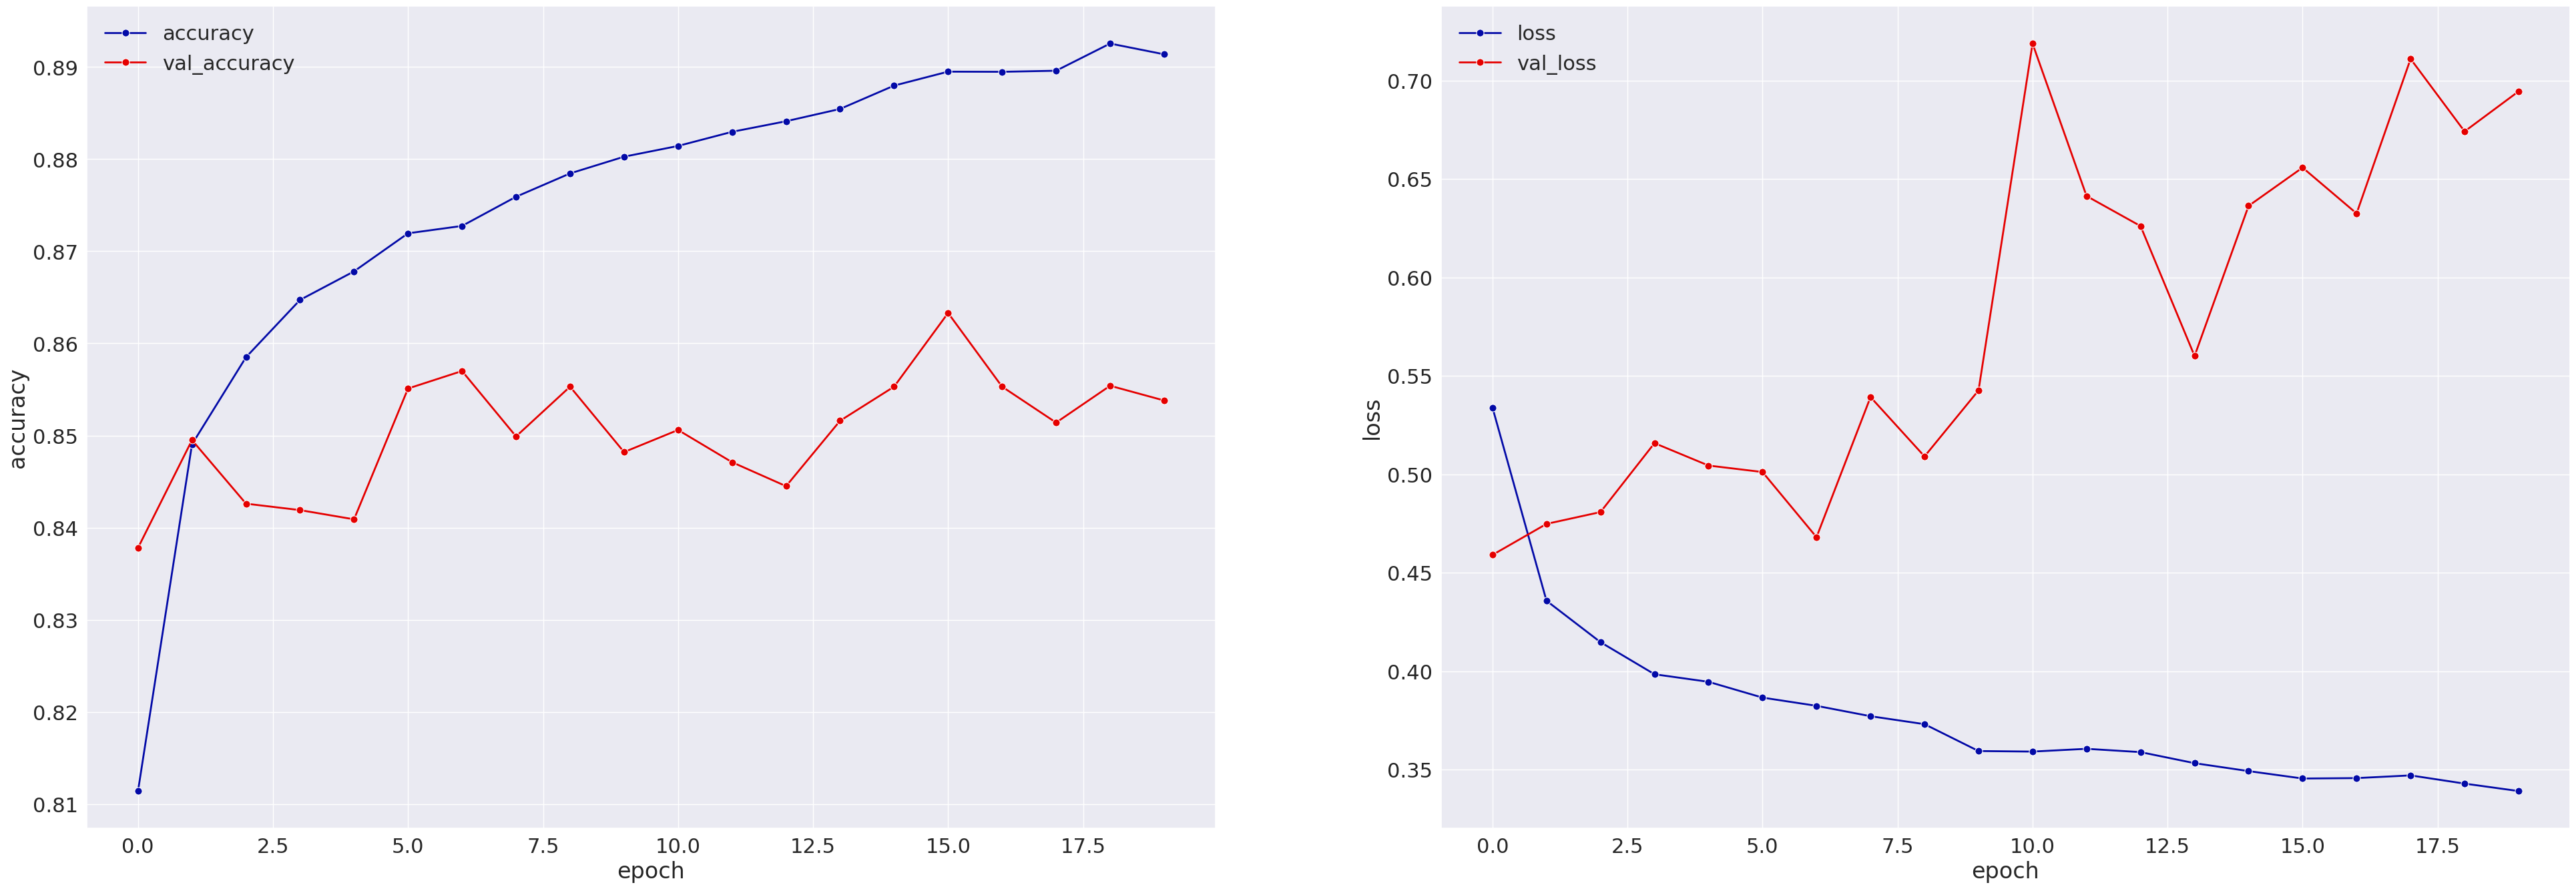

In [14]:
afficheHistoriqueEntrainement(history, palette)

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Sauvegarde du modèle </div></b>

In [15]:
one_hidden_layer_model.save(os.path.join(repertoireSauvegardes,'Keras-03-HistoriqueEntrainement.one_hidden_layer_history_batch_size_1.keras'))

In [16]:
sauvegarderModel(one_hidden_layer_model, 'one_hidden_layer_history_batch_size_1')

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Chargement du modèle </div></b>

In [17]:
model = tf.keras.models.load_model(os.path.join(repertoireSauvegardes,
                                   'Keras-03-HistoriqueEntrainement.one_hidden_layer_history_batch_size_1.keras'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 784)            │       615,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,869,872 (7.13 MB)

 Trainable params: 623,290 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,246,582 (4.76 MB)

In [18]:
model.fit( X_train.reshape((X_train.shape[0], number_of_pixels)), 
           y_train, 
           validation_data=(X_test.reshape((X_test.shape[0], number_of_pixels)), y_test), 
           epochs=2, 
           batch_size=batch_size, 
           verbose=1)

Epoch 1/2
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 44s 737us/step - accuracy: 0.8935 - loss: 0.3466 - val_accuracy: 0.8528 - val_loss: 0.6916
Epoch 2/2
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 50s 831us/step - accuracy: 0.8932 - loss: 0.3382 - val_accuracy: 0.8395 - val_loss: 0.8462


In [19]:
model.history.history

{'accuracy': [0.8926500082015991, 0.8927000164985657],
 'loss': [0.3461278975009918, 0.3391871750354767],
 'val_accuracy': [0.8528000116348267, 0.8395000100135803],
 'val_loss': [0.6915638446807861, 0.8461522459983826]}

In [20]:
h = pd.DataFrame( model.history.history)
h.reset_index(inplace=True)
h.rename(columns={'index':'epoch'},inplace=True)

In [21]:
h.epoch = h.epoch + 20

In [22]:
history = pd.concat([history,h],ignore_index=True)

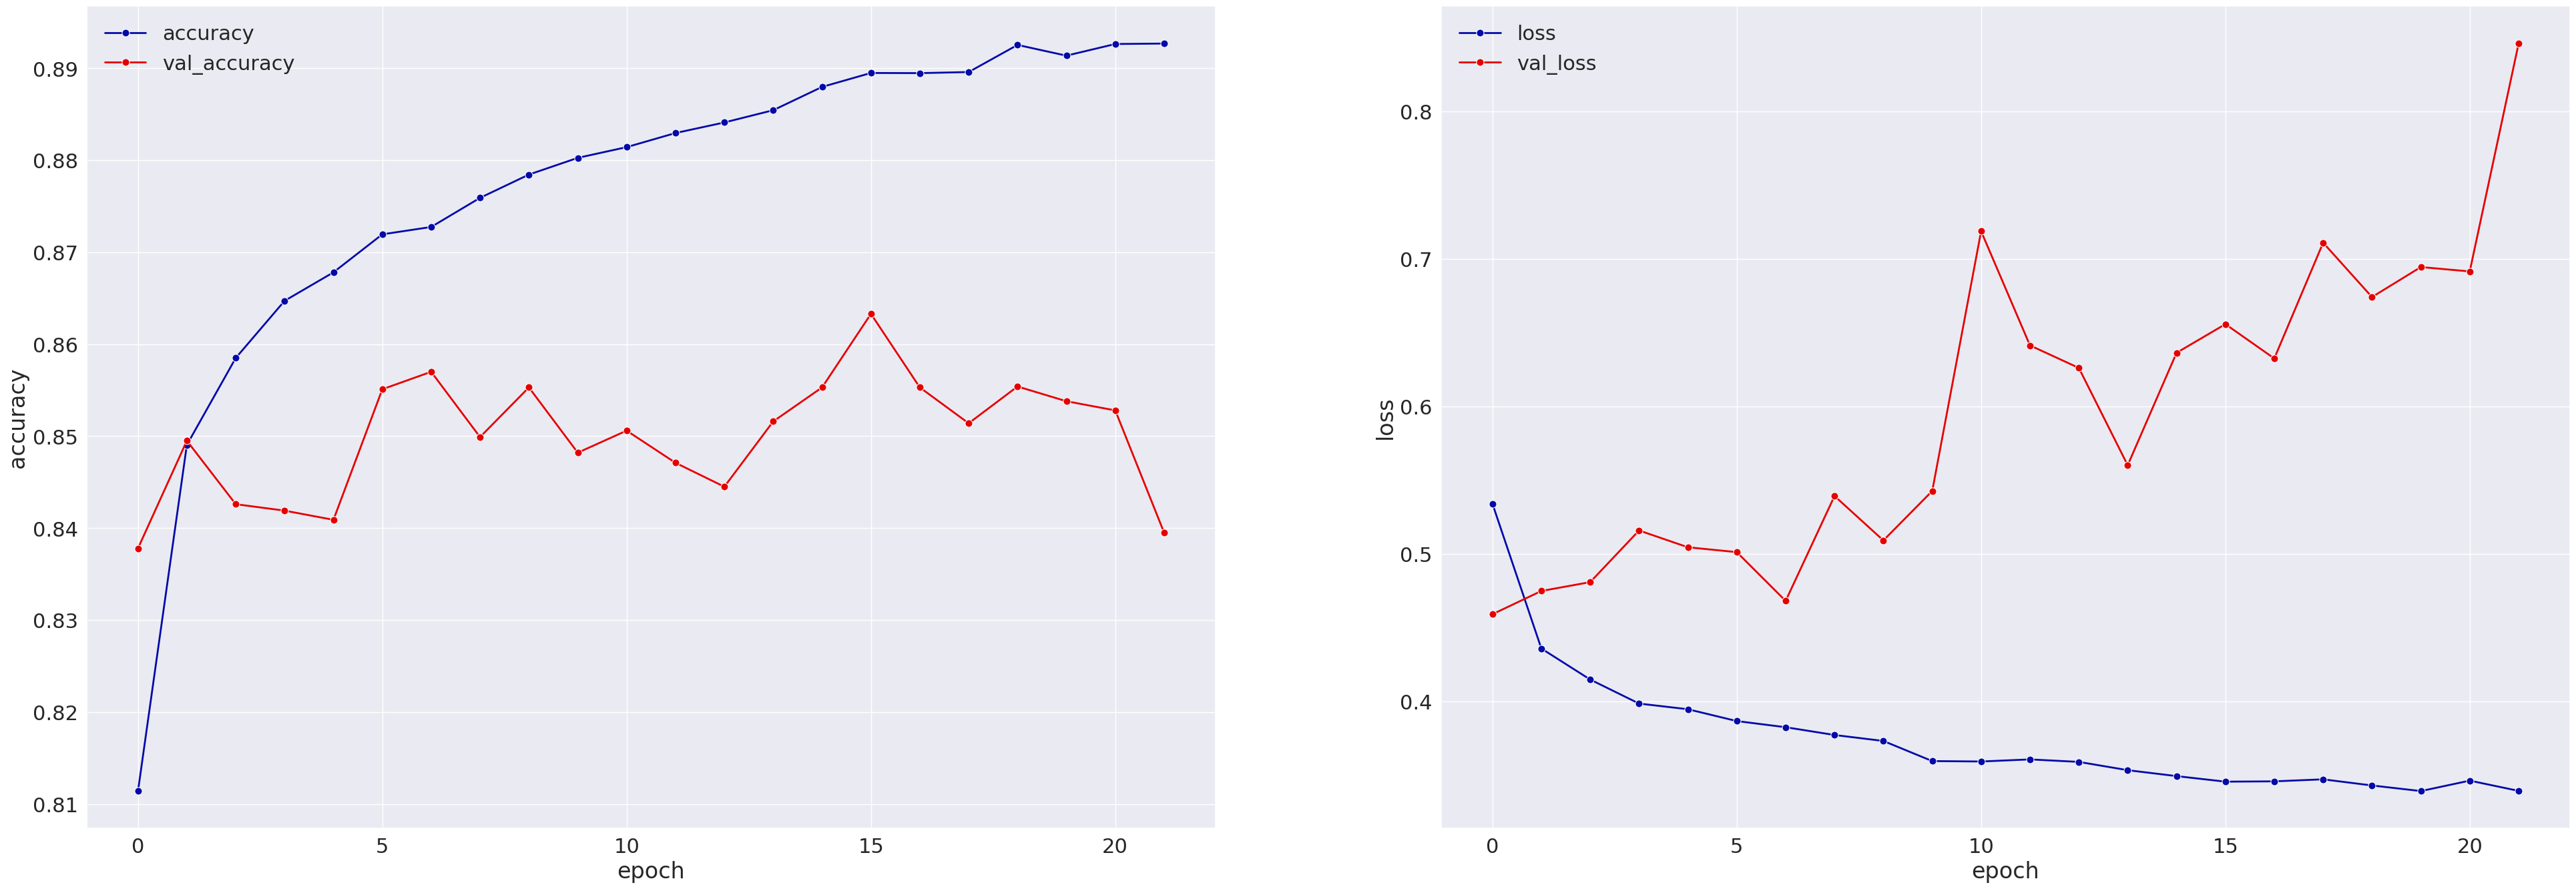

In [23]:
afficheHistoriqueEntrainement(history, palette)